In [1]:
import os
import platform
import subprocess
import numpy as np
import matplotlib.pyplot as plt
import re
import seaborn as sns
import pandas as pd

In [2]:
base_windows = "C:\\Users\\Miguel\\Downloads" # windows
base_linux = '/home/miguel/dev/dedup/data' # linux

os_name = platform.system()
base_path = base_windows if os_name == "Windows" else base_linux

folders = []
obj = os.scandir(base_path)
print("Files and Directories in '% s':" % base_path)
for entry in obj :
    if entry.is_dir() or entry.is_file():
        folders.append(entry.name)
        
plot_folders = ["videos", "textbooks", "images", "comp-images-zip", "comp-videos-zip"]

Files and Directories in '/home/miguel/dev/dedup/data':


In [3]:
class FastCDCScanResponse:
    def __init__(self, files, chunk_min, chunk_avg, chunk_max, unique_chunks, total_data, dupe_data, dedupe_ratio, throughput, throughput_unit):
        self.files = files
        self.chunk_min = chunk_min
        self.chunk_avg = chunk_avg
        self.chunk_max = chunk_max
        self.unique_chunks = unique_chunks
        self.total_data = total_data
        self.dupe_data = dupe_data
        self.dedupe_ratio = dedupe_ratio
        self.throughput = throughput
        self.throughput_unit = throughput_unit
        
def processFastCDCScanResponse(response):
    r = list(filter(None, re.split('\s|\n', response)))
    if len(r) == 30:
        obj = FastCDCScanResponse(r[1], r[5], r[8], r[11], r[14], r[17], r[21], r[25], r[28], r[29])
        return obj
    return None

def processFoldersbyChunk(folders, chunk_min, chunk_avg, chunk_max):
    responses = []
    for folder in folders:
        if not folder == 'memorydumps': 
            #print("Processing Folder: " + str(folder))
            command = "fastcdc scan " + base_path + "/" + str(folder) + " -r -mi " + str(chunk_min) + " -s "+ str(chunk_avg) + " -ma " + str(chunk_max)
            output = subprocess.check_output(command, shell=True).decode('utf-8')
            response = processFastCDCScanResponse(output)
            if response:
                responses.append(response)
    return responses

def processDedup(tests):
    o = []
    for chunk_size in tests.keys():
        j = []
        for folder in tests[chunk_size]:
            d = folder.dedupe_ratio
            j.append(float(d))
        o.append(j)
    return np.array(o)

def processThroughput(tests):
    o = []
    for chunk_size in tests.keys():
        j = []
        for folder in tests[chunk_size]:
            d = folder.throughput
            unit = folder.throughput_unit
            if unit == 'GB/s':
                j.append(float(d) * 1000)
            else:
                j.append(float(d))
        o.append(j)
    return np.array(o)

In [4]:
#Fixed 4096

num_tests = 10
curr_chunk_size = 4096
fixed_4096_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    fixed_4096_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size, curr_chunk_size, curr_chunk_size)
    curr_chunk_size += 4096
    
dedup_ratios_fixed_4096 = processDedup(fixed_4096_tests)
throughput_speeds_fixed_4096  = processThroughput(fixed_4096_tests)
#print(tests)


Test: 1 Chunk Size: 4096

Test: 2 Chunk Size: 8192

Test: 3 Chunk Size: 12288

Test: 4 Chunk Size: 16384

Test: 5 Chunk Size: 20480

Test: 6 Chunk Size: 24576

Test: 7 Chunk Size: 28672

Test: 8 Chunk Size: 32768

Test: 9 Chunk Size: 36864

Test: 10 Chunk Size: 40960


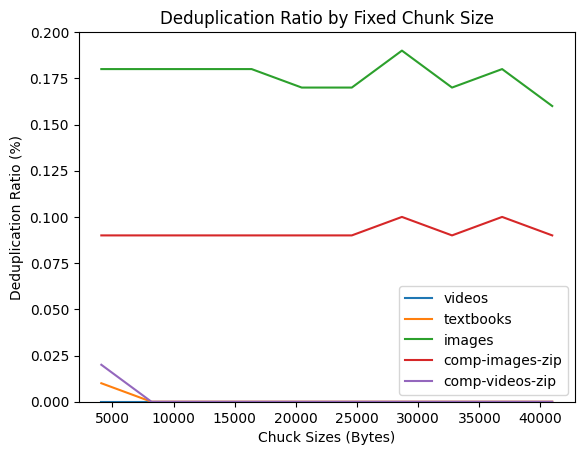

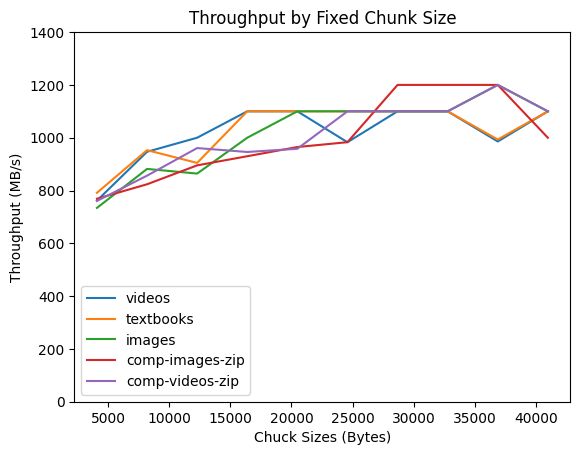

In [5]:
# Dedup Graph
dedup_ratios_fixed_4096_df = pd.DataFrame()
dedup_ratios_fixed_4096_df['chunk_sizes'] = fixed_4096_tests.keys()
for idx, data in enumerate(dedup_ratios_fixed_4096.T):
    dedup_ratios_fixed_4096_df[str(folders[idx])] = data
dedup_ratios_fixed_4096_g =dedup_ratios_fixed_4096_df.plot(x="chunk_sizes", y=plot_folders)
dedup_ratios_fixed_4096_g.set_ylim(0, 0.2)
dedup_ratios_fixed_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Fixed Chunk Size")
plt.show()

# Throughput Graph
throughput_speeds_fixed_4096_df = pd.DataFrame()
throughput_speeds_fixed_4096_df['chunk_sizes'] = fixed_4096_tests.keys()
for idx, data in enumerate(throughput_speeds_fixed_4096.T):
    throughput_speeds_fixed_4096_df[str(folders[idx])] = data
throughput_speeds_fixed_4096_g =throughput_speeds_fixed_4096_df.plot(x="chunk_sizes", y=plot_folders)
throughput_speeds_fixed_4096_g.set_ylim(0, 1400)
throughput_speeds_fixed_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Fixed Chunk Size")
plt.show()

In [6]:
#2048 Range

byte_range = 2048
num_tests = 10
curr_chunk_size = 4096
range_2048_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    range_2048_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - byte_range, curr_chunk_size, curr_chunk_size + byte_range)
    curr_chunk_size += 4096
    
dedup_ratios_range_2048 = processDedup(range_2048_tests)
throughput_speeds_range_2048  = processThroughput(range_2048_tests)
#print(tests)


Test: 1 Chunk Size: 4096

Test: 2 Chunk Size: 8192

Test: 3 Chunk Size: 12288

Test: 4 Chunk Size: 16384

Test: 5 Chunk Size: 20480

Test: 6 Chunk Size: 24576

Test: 7 Chunk Size: 28672

Test: 8 Chunk Size: 32768

Test: 9 Chunk Size: 36864

Test: 10 Chunk Size: 40960


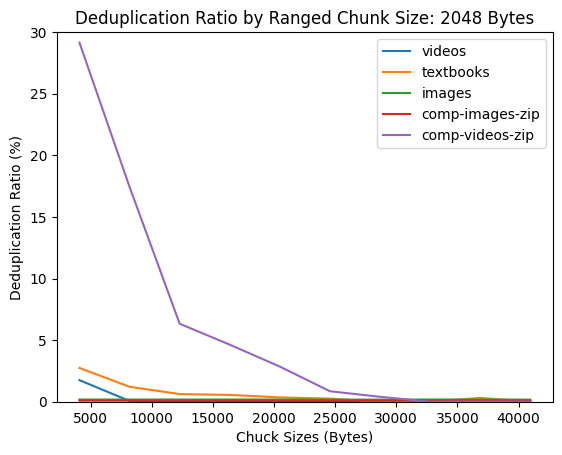

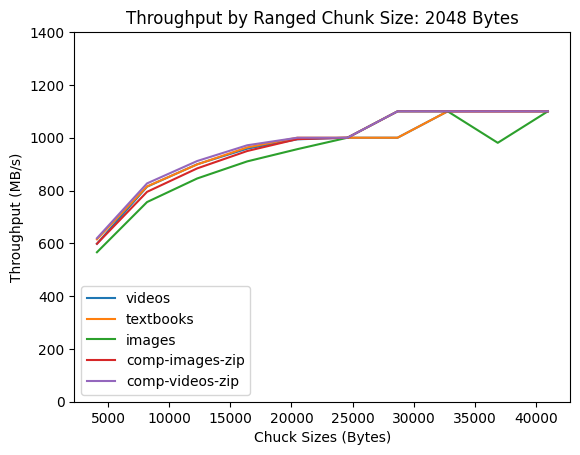

In [7]:
# Dedup Graph
dedup_ratios_range_2048_df = pd.DataFrame()
dedup_ratios_range_2048_df['chunk_sizes'] = range_2048_tests.keys()
for idx, data in enumerate(dedup_ratios_range_2048.T):
    dedup_ratios_range_2048_df[str(folders[idx])] = data
dedup_ratios_range_2048_g =dedup_ratios_range_2048_df.plot(x="chunk_sizes", y=plot_folders)
dedup_ratios_range_2048_g.set_ylim(0, 30)
dedup_ratios_range_2048_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 2048 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_range_2048_df = pd.DataFrame()
throughput_speeds_range_2048_df['chunk_sizes'] = range_2048_tests.keys()
for idx, data in enumerate(throughput_speeds_range_2048.T):
    throughput_speeds_range_2048_df[str(folders[idx])] = data
throughput_speeds_range_2048_g =throughput_speeds_range_2048_df.plot(x="chunk_sizes", y=plot_folders)
throughput_speeds_range_2048_g.set_ylim(0, 1400)
throughput_speeds_range_2048_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 2048 Bytes")
plt.show()

In [8]:
#4096 Range

byte_range = 4096
num_tests = 10
curr_chunk_size = 8192
range_4096_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    range_4096_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - byte_range, curr_chunk_size, curr_chunk_size + byte_range)
    curr_chunk_size += 4096
    
dedup_ratios_range_4096 = processDedup(range_4096_tests)
throughput_speeds_range_4096  = processThroughput(range_4096_tests)
#print(tests)


Test: 1 Chunk Size: 8192

Test: 2 Chunk Size: 12288

Test: 3 Chunk Size: 16384

Test: 4 Chunk Size: 20480

Test: 5 Chunk Size: 24576

Test: 6 Chunk Size: 28672

Test: 7 Chunk Size: 32768

Test: 8 Chunk Size: 36864

Test: 9 Chunk Size: 40960

Test: 10 Chunk Size: 45056


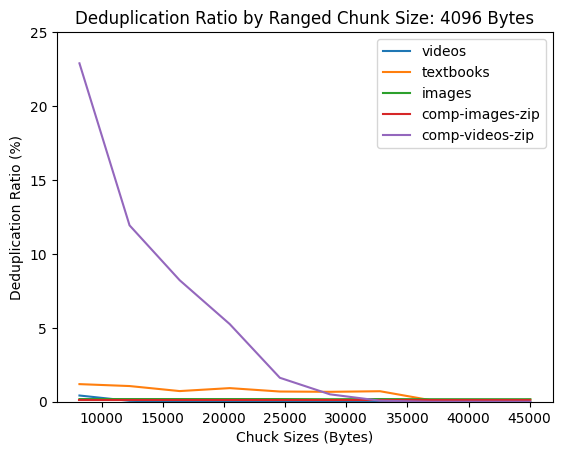

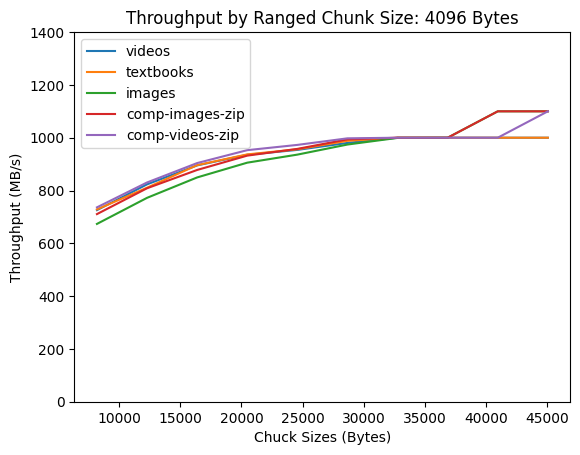

In [9]:
# Dedup Graph
dedup_ratios_range_4096_df = pd.DataFrame()
dedup_ratios_range_4096_df['chunk_sizes'] = range_4096_tests.keys()
for idx, data in enumerate(dedup_ratios_range_4096.T):
    dedup_ratios_range_4096_df[str(folders[idx])] = data
dedup_ratios_range_4096_g =dedup_ratios_range_4096_df.plot(x="chunk_sizes", y=plot_folders)
dedup_ratios_range_4096_g.set_ylim(0, 25)
dedup_ratios_range_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 4096 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_range_4096_df = pd.DataFrame()
throughput_speeds_range_4096_df['chunk_sizes'] = range_4096_tests.keys()
for idx, data in enumerate(throughput_speeds_range_4096.T):
    throughput_speeds_range_4096_df[str(folders[idx])] = data
throughput_speeds_range_4096_g =throughput_speeds_range_4096_df.plot(x="chunk_sizes", y=plot_folders)
throughput_speeds_range_4096_g.set_ylim(0, 1400)
throughput_speeds_range_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 4096 Bytes")
plt.show()

In [10]:
#8192 Range

byte_range = 8192
num_tests = 10
curr_chunk_size = 12288
range_8192_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    range_8192_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - byte_range, curr_chunk_size, curr_chunk_size + byte_range)
    curr_chunk_size += 4096
    
dedup_ratios_range_8192 = processDedup(range_8192_tests)
throughput_speeds_range_8192  = processThroughput(range_8192_tests)
#print(tests)


Test: 1 Chunk Size: 12288

Test: 2 Chunk Size: 16384

Test: 3 Chunk Size: 20480

Test: 4 Chunk Size: 24576

Test: 5 Chunk Size: 28672

Test: 6 Chunk Size: 32768

Test: 7 Chunk Size: 36864

Test: 8 Chunk Size: 40960

Test: 9 Chunk Size: 45056

Test: 10 Chunk Size: 49152


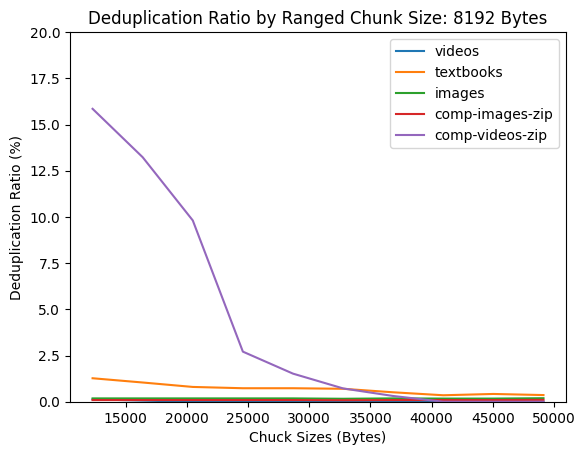

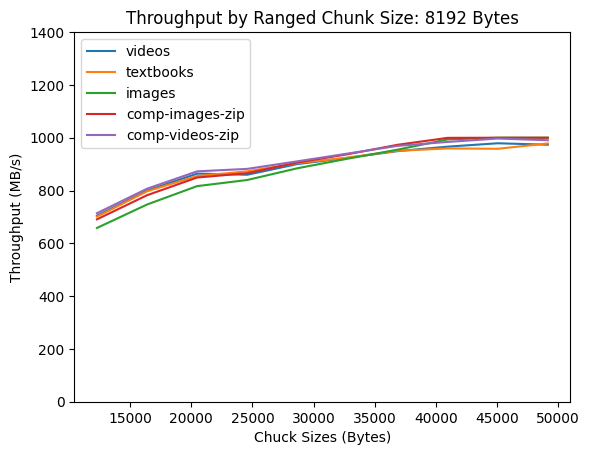

In [11]:
# Dedup Graph
dedup_ratios_range_8192_df = pd.DataFrame()
dedup_ratios_range_8192_df['chunk_sizes'] = range_8192_tests.keys()
for idx, data in enumerate(dedup_ratios_range_8192.T):
    dedup_ratios_range_8192_df[str(folders[idx])] = data
dedup_ratios_range_8192_g =dedup_ratios_range_8192_df.plot(x="chunk_sizes", y=plot_folders)
dedup_ratios_range_8192_g.set_ylim(0, 20)
dedup_ratios_range_8192_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 8192 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_range_8192_df = pd.DataFrame()
throughput_speeds_range_8192_df['chunk_sizes'] = range_8192_tests.keys()
for idx, data in enumerate(throughput_speeds_range_8192.T):
    throughput_speeds_range_8192_df[str(folders[idx])] = data
throughput_speeds_range_8192_g =throughput_speeds_range_8192_df.plot(x="chunk_sizes", y=plot_folders)
throughput_speeds_range_8192_g.set_ylim(0, 1400)
throughput_speeds_range_8192_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 8192 Bytes")
plt.show()

videos


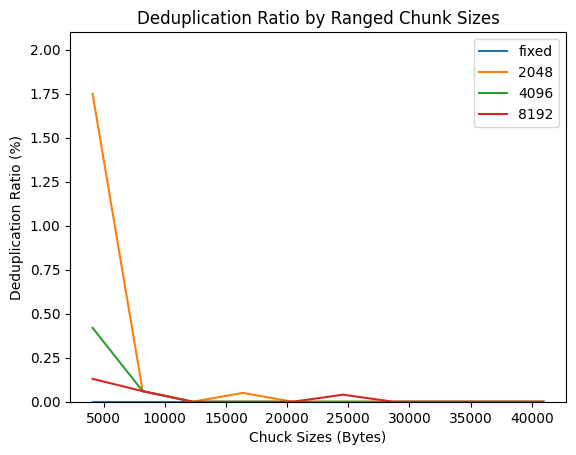

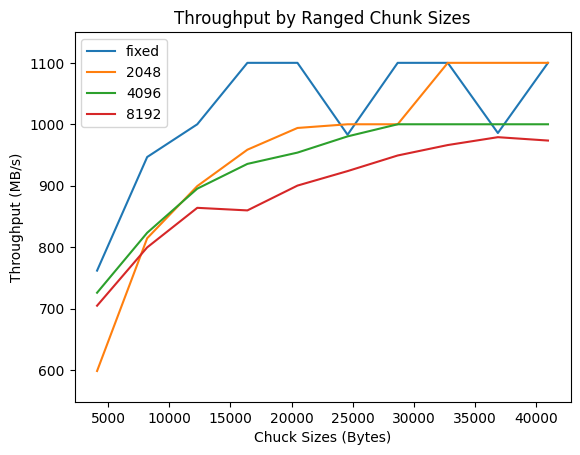

textbooks


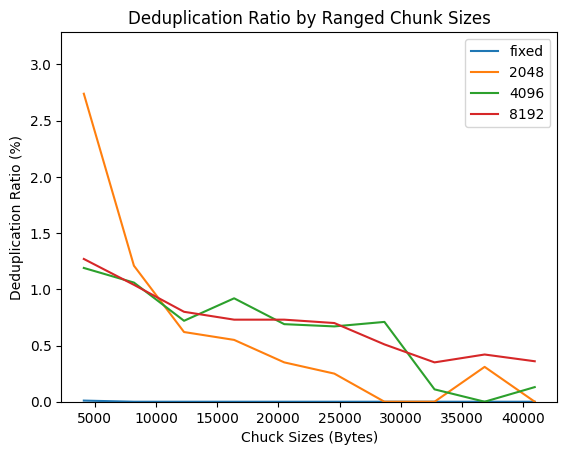

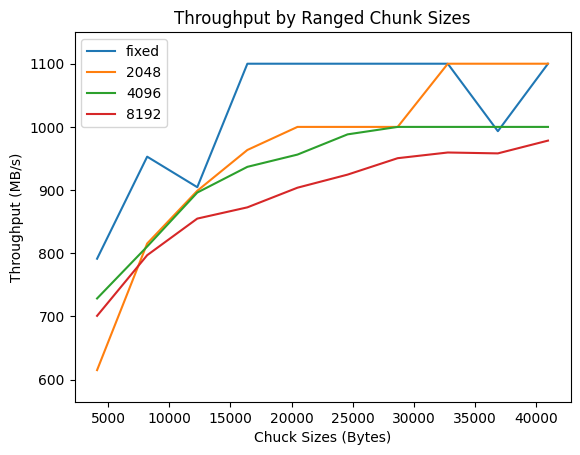

images


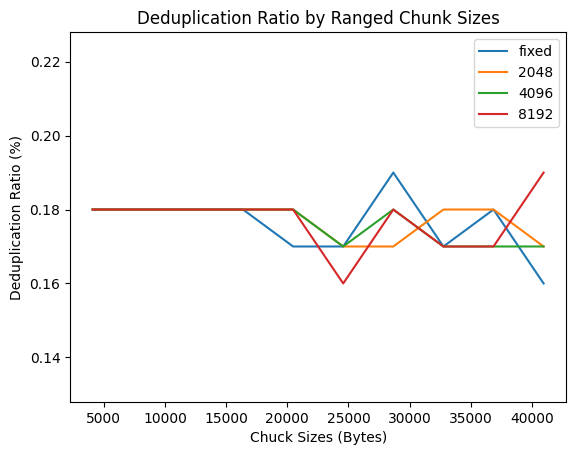

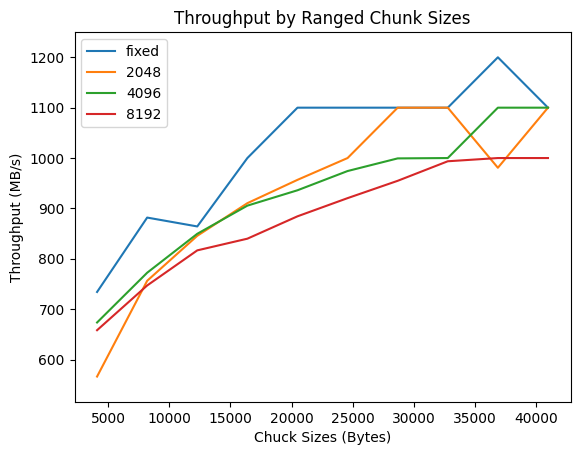

comp-images-zip


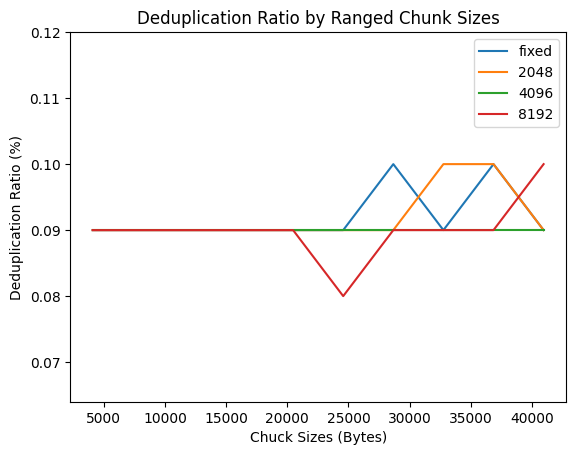

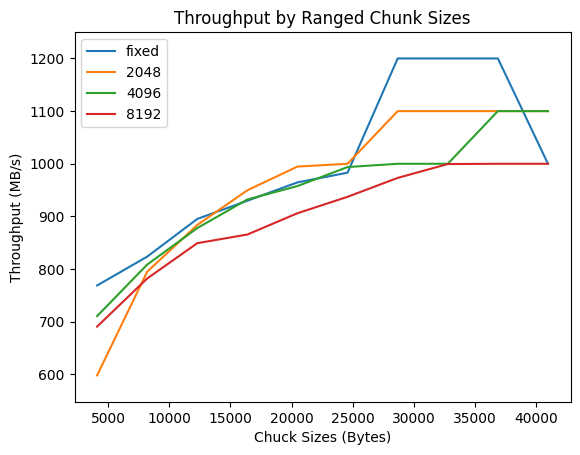

comp-videos-zip


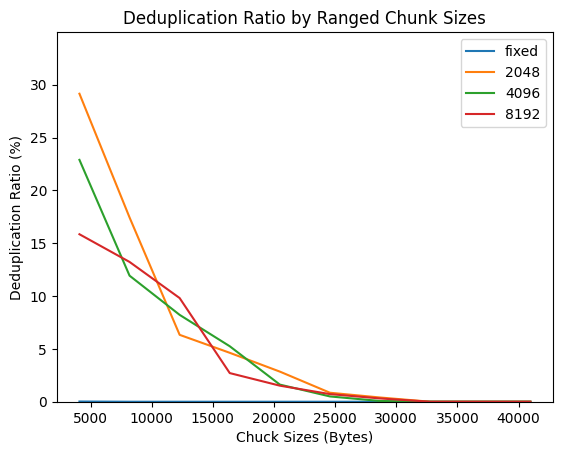

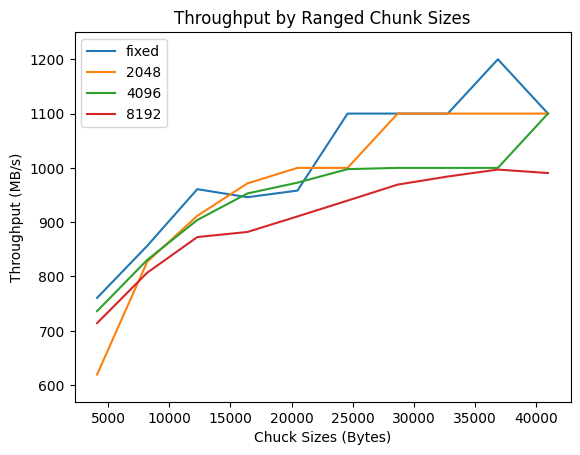

In [12]:
for folder in plot_folders:
    print(folder)
    dedup_ratios_all_clean_df = pd.DataFrame()
    dedup_ratios_all_clean_df['chunk_sizes'] = dedup_ratios_fixed_4096_df['chunk_sizes']
    dedup_ratios_all_clean_df['fixed'] = dedup_ratios_fixed_4096_df[folder]
    dedup_ratios_all_clean_df['2048'] = dedup_ratios_range_2048_df[folder]
    dedup_ratios_all_clean_df['4096'] = dedup_ratios_range_4096_df[folder]
    dedup_ratios_all_clean_df['8192'] = dedup_ratios_range_8192_df[folder]
    
    range_min = min(dedup_ratios_all_clean_df['fixed'].min(), dedup_ratios_all_clean_df['2048'].min(), dedup_ratios_all_clean_df['4096'].min(), dedup_ratios_all_clean_df['8192'].min())
    range_max = max(dedup_ratios_all_clean_df['fixed'].max(), dedup_ratios_all_clean_df['2048'].max(), dedup_ratios_all_clean_df['4096'].max(), dedup_ratios_all_clean_df['8192'].max())

    dedup_ratios_all_clean_g =dedup_ratios_all_clean_df.plot(x="chunk_sizes", y=["fixed", "2048", "4096", "8192"])
    dedup_ratios_all_clean_g.set_ylim(max(0, range_min - (range_min * 0.2)), range_max * 1.2)
    dedup_ratios_all_clean_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Sizes")
    plt.show()

    throughput_speeds_all_df = pd.DataFrame()
    throughput_speeds_all_df['chunk_sizes'] = throughput_speeds_fixed_4096_df['chunk_sizes']
    throughput_speeds_all_df['fixed'] = throughput_speeds_fixed_4096_df[folder]
    throughput_speeds_all_df['2048'] = throughput_speeds_range_2048_df[folder]
    throughput_speeds_all_df['4096'] = throughput_speeds_range_4096_df[folder]
    throughput_speeds_all_df['8192'] = throughput_speeds_range_8192_df[folder]
    
    range_min = min(throughput_speeds_all_df['fixed'].min(), throughput_speeds_all_df['2048'].min(), throughput_speeds_all_df['4096'].min(), throughput_speeds_all_df['8192'].min())
    range_max = max(throughput_speeds_all_df['fixed'].max(), throughput_speeds_all_df['2048'].max(), throughput_speeds_all_df['4096'].max(), throughput_speeds_all_df['8192'].max())

    throughput_speeds_all_g =throughput_speeds_all_df.plot(x="chunk_sizes", y=["fixed", "2048", "4096", "8192"])
    throughput_speeds_all_g.set_ylim(max(0, range_min - 50), range_max + 50)
    throughput_speeds_all_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Sizes")
    plt.show()

## Memory Dumps

### C

In [ ]:
from elftools.elf.elffile import ELFFile

memorydump_files = []
obj = os.scandir(base_path + '/memorydumps/initial/C')
print("Files and Directories in '% s':" % (base_path + '/memorydumps/initial/C'))
for entry in obj :
    if not entry.is_dir() or entry.is_file():
        memorydump_files.append(entry.name)

In [ ]:
for file in memorydump_files:
    with open(base_linux + f'/memorydumps/initial/C/{file}', 'rb') as f:
        print(f"Processing File: {file}")
        
        # Create an ELFFile object
        elf = ELFFile(f)

        # Read the ELF header
        print('ELF Type:', elf.header['e_type'])
        print('Machine Architecture:', elf.header['e_machine'])

        # Read the section header table
        sh_table = elf.get_section_by_name('.shstrtab')
        for section in elf.iter_sections():
            print('Section:', section.name)
            print('Size:', section['sh_size'])
            print('Address:', hex(section['sh_addr']))
        print("End Of File \n")

In [ ]:
def all_zero(bytes_read): 
    for byte in bytes_read:
        if not byte == 0:
            return False
    return True

In [ ]:
for file in memorydump_files:
    with open(base_linux + f'/memorydumps/initial/C/{file}', 'rb') as f:
        print(f"Processing File: {file}")
        
        all_zero_pages_count = 0
        total_pages = 0
        
        with open(base_linux + f'/memorydumps/clean/C/{file}_2', 'wb') as output_file:
            
            while (bytes_read := f.read(4096)):
                total_pages += 1

                if not bytes:
                    break

                all_zeros = all_zero(bytes_read)
                if all_zeros == True:

                    modified_data = bytes_read.replace(b'\x00', b'')
                    output_file.write(modified_data)

                    all_zero_pages_count += 1
                else:
                    output_file.write(bytes_read)
            
        print(f"Found {all_zero_pages_count} all-zero pages")  
        print(f"Found {total_pages} total pages")
        

In [ ]:
# Check for all-zero pages
for file in memorydump_files:
    with open(base_linux + f'/memorydumps/clean/C/{file}_2', 'rb') as f:
        print(f"Processing File: {file}")
        
        all_zero_pages_count = 0
        total_pages = 0
        
       
        while (bytes_read := f.read(4096)):
            total_pages += 1

            if not bytes:
                break

            all_zeros = all_zero(bytes_read)
            if all_zeros == True:
                all_zero_pages_count += 1
            
        print(f"Found {all_zero_pages_count} all-zero pages")  
        print(f"Found {total_pages} total pages")
        

In [112]:
# Memory Dump Range 2048
folders = ['/memorydumps/initial/C', '/memorydumps/clean/C']

range_bytes = 2048
num_tests = 10
curr_chunk_size = 4096
memory_range_2048_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    memory_range_2048_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - range_bytes, curr_chunk_size, curr_chunk_size + range_bytes)
    curr_chunk_size += 4096
    
dedup_ratios_memory_range_2048 = processDedup(memory_range_2048_tests)
throughput_speeds_memory_range_2048  = processThroughput(memory_range_2048_tests)
#print(tests)


Test: 1 Chunk Size: 4096

Test: 2 Chunk Size: 8192

Test: 3 Chunk Size: 12288

Test: 4 Chunk Size: 16384

Test: 5 Chunk Size: 20480

Test: 6 Chunk Size: 24576

Test: 7 Chunk Size: 28672

Test: 8 Chunk Size: 32768

Test: 9 Chunk Size: 36864

Test: 10 Chunk Size: 40960


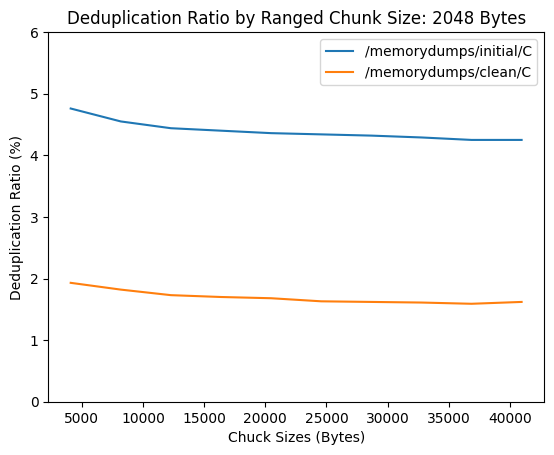

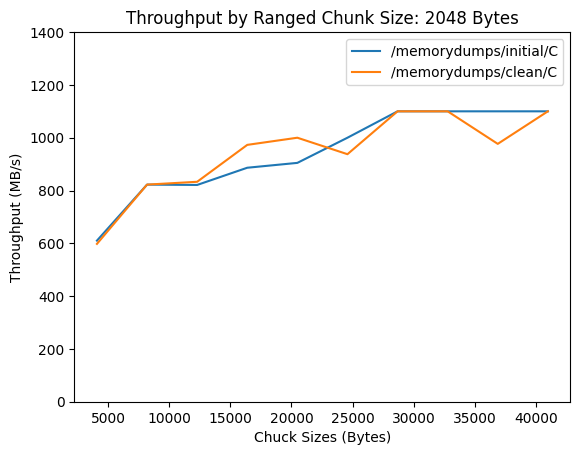

In [113]:
# Dedup Graph
dedup_ratios_memory_range_2048_df = pd.DataFrame()
dedup_ratios_memory_range_2048_df['chunk_sizes'] = memory_range_2048_tests.keys()
for idx, data in enumerate(dedup_ratios_memory_range_2048.T):
    dedup_ratios_memory_range_2048_df[str(folders[idx])] = data
dedup_ratios_memory_range_2048_g =dedup_ratios_memory_range_2048_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
dedup_ratios_memory_range_2048_g.set_ylim(0, 6)
dedup_ratios_memory_range_2048_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 2048 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_memory_range_2048_df = pd.DataFrame()
throughput_speeds_memory_range_2048_df['chunk_sizes'] = memory_range_2048_tests.keys()
for idx, data in enumerate(throughput_speeds_memory_range_2048.T):
    throughput_speeds_memory_range_2048_df[str(folders[idx])] = data
throughput_speeds_memory_range_2048_g =throughput_speeds_memory_range_2048_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
throughput_speeds_memory_range_2048_g.set_ylim(0, 1400)
throughput_speeds_memory_range_2048_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 2048 Bytes")
plt.show()

In [114]:
# Memory Dump Range 4096
folders = ['/memorydumps/initial/C', '/memorydumps/clean/C']

range_bytes = 4096
num_tests = 10
curr_chunk_size = 8192
memory_range_4096_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    memory_range_4096_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - range_bytes, curr_chunk_size, curr_chunk_size + range_bytes)
    curr_chunk_size += 4096
    
dedup_ratios_memory_range_4096 = processDedup(memory_range_4096_tests)
throughput_speeds_memory_range_4096  = processThroughput(memory_range_4096_tests)
#print(tests)


Test: 1 Chunk Size: 8192

Test: 2 Chunk Size: 12288

Test: 3 Chunk Size: 16384

Test: 4 Chunk Size: 20480

Test: 5 Chunk Size: 24576

Test: 6 Chunk Size: 28672

Test: 7 Chunk Size: 32768

Test: 8 Chunk Size: 36864

Test: 9 Chunk Size: 40960

Test: 10 Chunk Size: 45056


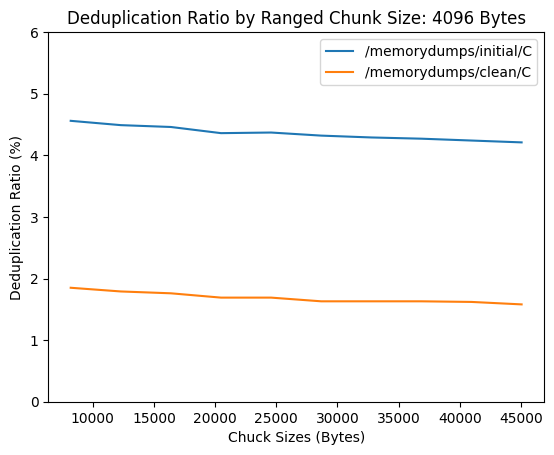

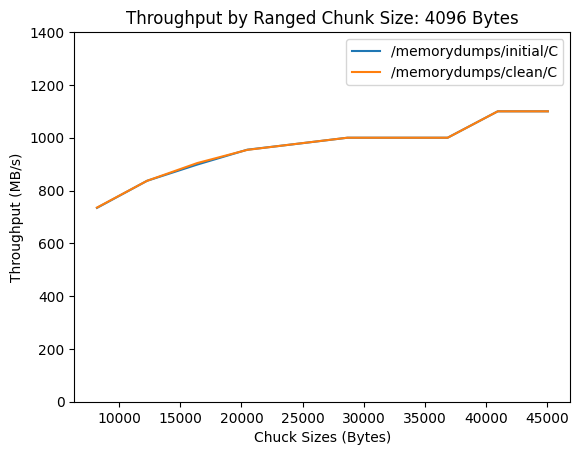

In [116]:
# Dedup Graph
dedup_ratios_memory_range_4096_df = pd.DataFrame()
dedup_ratios_memory_range_4096_df['chunk_sizes'] = memory_range_4096_tests.keys()
for idx, data in enumerate(dedup_ratios_memory_range_4096.T):
    dedup_ratios_memory_range_4096_df[str(folders[idx])] = data
dedup_ratios_memory_range_4096_g =dedup_ratios_memory_range_4096_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
dedup_ratios_memory_range_4096_g.set_ylim(0, 6)
dedup_ratios_memory_range_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 4096 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_memory_range_4096_df = pd.DataFrame()
throughput_speeds_memory_range_4096_df['chunk_sizes'] = memory_range_4096_tests.keys()
for idx, data in enumerate(throughput_speeds_memory_range_4096.T):
    throughput_speeds_memory_range_4096_df[str(folders[idx])] = data
throughput_speeds_memory_range_4096_g =throughput_speeds_memory_range_4096_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
throughput_speeds_memory_range_4096_g.set_ylim(0, 1400)
throughput_speeds_memory_range_4096_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 4096 Bytes")
plt.show()

In [118]:
# Memory Dump Range 8192
folders = ['/memorydumps/initial/C', '/memorydumps/clean/C']

range_bytes = 8192
num_tests = 10
curr_chunk_size = 12288
memory_range_8192_tests = {}
for i in range(1, num_tests + 1):
    print("\nTest: " + str(i) + " Chunk Size: " + str(curr_chunk_size))
    memory_range_8192_tests[curr_chunk_size] = processFoldersbyChunk(folders, curr_chunk_size - range_bytes, curr_chunk_size, curr_chunk_size + range_bytes)
    curr_chunk_size += 4096
    
dedup_ratios_memory_range_8192 = processDedup(memory_range_8192_tests)
throughput_speeds_memory_range_8192  = processThroughput(memory_range_8192_tests)
#print(tests)


Test: 1 Chunk Size: 12288

Test: 2 Chunk Size: 16384

Test: 3 Chunk Size: 20480

Test: 4 Chunk Size: 24576

Test: 5 Chunk Size: 28672

Test: 6 Chunk Size: 32768

Test: 7 Chunk Size: 36864

Test: 8 Chunk Size: 40960

Test: 9 Chunk Size: 45056

Test: 10 Chunk Size: 49152


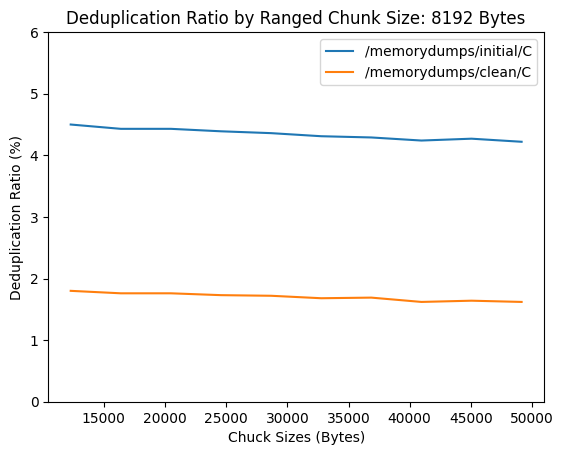

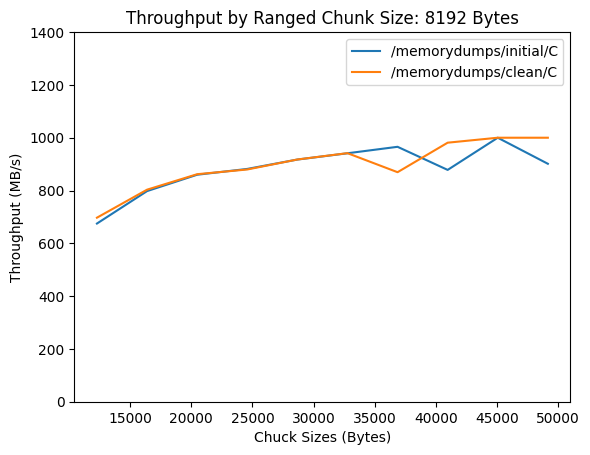

In [119]:
# Dedup Graph
dedup_ratios_memory_range_8192_df = pd.DataFrame()
dedup_ratios_memory_range_8192_df['chunk_sizes'] = memory_range_8192_tests.keys()
for idx, data in enumerate(dedup_ratios_memory_range_8192.T):
    dedup_ratios_memory_range_8192_df[str(folders[idx])] = data
dedup_ratios_memory_range_8192_g =dedup_ratios_memory_range_8192_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
dedup_ratios_memory_range_8192_g.set_ylim(0, 6)
dedup_ratios_memory_range_8192_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Size: 8192 Bytes")
plt.show()

# Throughput Graph
throughput_speeds_memory_range_8192_df = pd.DataFrame()
throughput_speeds_memory_range_8192_df['chunk_sizes'] = memory_range_8192_tests.keys()
for idx, data in enumerate(throughput_speeds_memory_range_8192.T):
    throughput_speeds_memory_range_8192_df[str(folders[idx])] = data
throughput_speeds_memory_range_8192_g =throughput_speeds_memory_range_8192_df.plot(x="chunk_sizes", y=["/memorydumps/initial/C", "/memorydumps/clean/C"])
throughput_speeds_memory_range_8192_g.set_ylim(0, 1400)
throughput_speeds_memory_range_8192_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Size: 8192 Bytes")
plt.show()

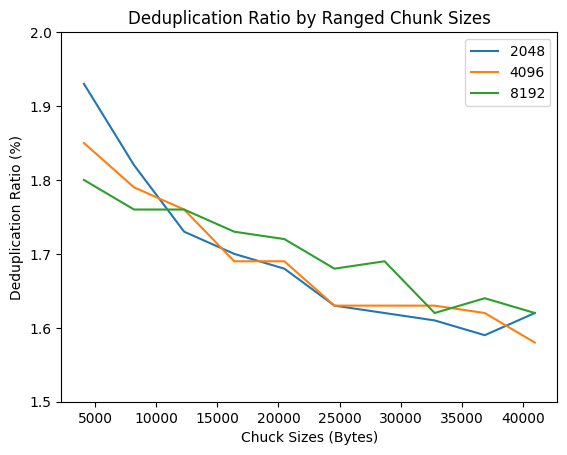

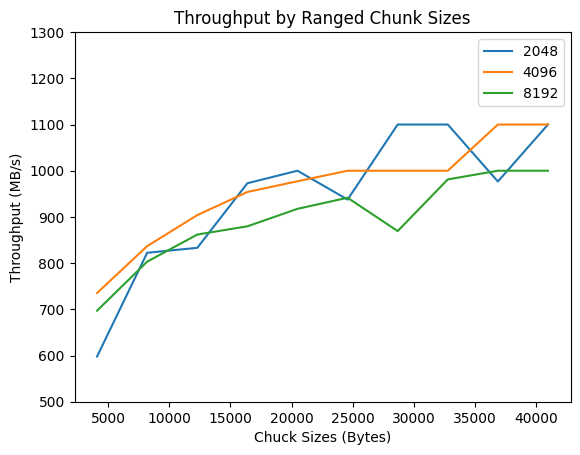

In [135]:
dedup_ratios_memory_range_all_clean_df = pd.DataFrame()
dedup_ratios_memory_range_all_clean_df['chunk_sizes'] = dedup_ratios_memory_range_2048_df['chunk_sizes']
dedup_ratios_memory_range_all_clean_df['2048'] = dedup_ratios_memory_range_2048_df['/memorydumps/clean/C']
dedup_ratios_memory_range_all_clean_df['4096'] = dedup_ratios_memory_range_4096_df['/memorydumps/clean/C']
dedup_ratios_memory_range_all_clean_df['8192'] = dedup_ratios_memory_range_8192_df['/memorydumps/clean/C']

dedup_ratios_memory_range_all_clean_g =dedup_ratios_memory_range_all_clean_df.plot(x="chunk_sizes", y=["2048", "4096", "8192"])
dedup_ratios_memory_range_all_clean_g.set_ylim(1.5, 2)
dedup_ratios_memory_range_all_clean_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Deduplication Ratio (%)", title ="Deduplication Ratio by Ranged Chunk Sizes")
plt.show()

dedup_ratios_memory_range_all_initial_df = pd.DataFrame()
dedup_ratios_memory_range_all_initial_df['chunk_sizes'] = throughput_speeds_memory_range_2048_df['chunk_sizes']
dedup_ratios_memory_range_all_initial_df['2048'] = throughput_speeds_memory_range_2048_df['/memorydumps/clean/C']
dedup_ratios_memory_range_all_initial_df['4096'] = throughput_speeds_memory_range_4096_df['/memorydumps/clean/C']
dedup_ratios_memory_range_all_initial_df['8192'] = throughput_speeds_memory_range_8192_df['/memorydumps/clean/C']

dedup_ratios_memory_range_all_initial_g =dedup_ratios_memory_range_all_initial_df.plot(x="chunk_sizes", y=["2048", "4096", "8192"])
dedup_ratios_memory_range_all_initial_g.set_ylim(500, 1300)
dedup_ratios_memory_range_all_initial_g.set(xlabel ="Chuck Sizes (Bytes)", ylabel = "Throughput (MB/s)", title ="Throughput by Ranged Chunk Sizes")
plt.show()
